# 3D Sensing and Sensor Fusion
### Second Assignment - Kelemen Réka (E6T1DT)
***

In [1]:
import cv2
import os
import random
import numpy as np
from numba import jit
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from skimage.metrics import structural_similarity as SSIM, mean_squared_error as MSE

In [2]:
@jit(nopython=True)
def bilateral_filter(image, window=5, sigma_spatial=20, sigma_spectral=20):
    out_image = np.zeros_like(image, dtype=np.uint8)
    half_window_size = window // 2
    height, width = image.shape

    for h in range(height):
        for w in range(width):
            sum_ = 0.0
            weight_sum = 0.0

            for i in range(-half_window_size, half_window_size + 1):
                for j in range(-half_window_size, half_window_size + 1):
                    k = h + i
                    l = w + j

                    if k >= height:
                        k -= height

                    if l >= width:
                        l -= width

                    weight = np.exp(
                        -(((h - k) ** 2 + (w - l) ** 2) / (2 * sigma_spectral ** 2))
                        - ((image[h, w] - image[k, l]) ** 2 / (2 * sigma_spatial ** 2))
                    )

                    sum_ += image[k, l] * weight
                    weight_sum += weight

            out_image[h, w] = int(np.round(sum_ // weight_sum))
    return out_image

In [3]:
@jit(nopython=True)
def joint_bilateral_filter(image, guide, window=5, sigma_spatial=20, sigma_spectral=20):
    out_image = np.zeros_like(image, dtype=np.uint8)
    half_window_size = window // 2
    height, width = image.shape

    for h in range(height):
        for w in range(width):
            sum_ = 0.0
            weight_sum = 0.0

            for i in range(-half_window_size, half_window_size + 1):
                for j in range(-half_window_size, half_window_size + 1):
                    k = h + i
                    l = w + j

                    if k >= height:
                        k -= height

                    if l >= width:
                        l -= width

                    weight = np.exp(
                        -(((h - k) ** 2 + (w - l) ** 2) / (2 * sigma_spectral ** 2))
                        - ((guide[h, w] - guide[k, l]) ** 2 / (2 * sigma_spatial ** 2))
                    )

                    sum_ += image[k, l] * weight
                    weight_sum += weight

            out_image[h, w] = int(np.round(sum_ // weight_sum))
    return out_image

# Bilateral Filter

In [4]:
working_dir = os.getcwd()
print(working_dir)

C:\Users\rekak\Downloads\3DSSF 2nd Assignment


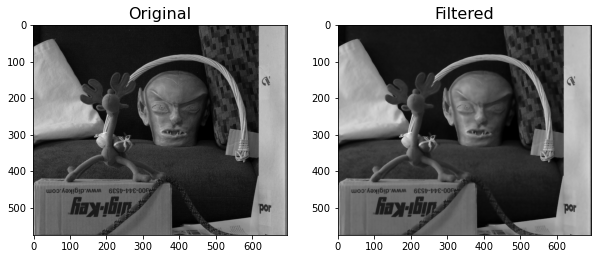

In [5]:
image = cv2.imread(working_dir + "/images/reindeer1.png", cv2.IMREAD_GRAYSCALE)
filtered = bilateral_filter(image, window=5, sigma_spatial=20, sigma_spectral=20)

plt.figure(figsize=(10, 5))
titles = ["Original", "Filtered"]
images = [image, filtered]
for i in range(1, 3):
    plt.subplot(120 + i)
    plt.title(titles[i - 1], fontsize=16)
    plt.imshow(images[i - 1], cmap="gray")

# Impact of Variables

In [6]:
def plot_variable_effect(file_name, variable_name, list_of_values):
    image = cv2.imread("images/" + file_name, cv2.IMREAD_GRAYSCALE)
    params = {}
    length = len(list_of_values)

    plt.figure(figsize=(16, 5))
    for i in range(length):
        params[variable_name] = list_of_values[i]
        image_bilateral = bilateral_filter(image, **params)
        plt.subplot(1, length, i + 1)
        plt.title(str(variable_name) + " = " + str(list_of_values[i]), fontsize=16)
        plt.imshow(image_bilateral, cmap="gray")
    plt.savefig(working_dir + "/output/" + variable_name + "_effect.png")
    plt.show()

In [ ]:
plot_variable_effect("art1.png", "window", [5, 10, 15, 20, 30])
plot_variable_effect("art1.png", "sigma_spatial", [5, 10, 20, 40, 70])
plot_variable_effect("art1.png", "sigma_spectral", [5, 10, 20, 40, 70])

# All Combinations

In [ ]:
plt.figure(figsize=(20, 20))
sigma_list = [5, 10, 30, 50]  
k = 0
for i in range(4):
    for j in range(4):
        plt.subplot(4, 4, k + 1)
        sigma_spatial = sigma_list[i]
        sigma_spectral = sigma_list[j]
        plt.title("sigma_spatial = " + str(sigma_spatial) + "\n" + "sigma_spectral = " + str(sigma_spectral), fontsize=16)
        filtered = bilateral_filter(image, window=15, sigma_spatial=sigma_spatial, sigma_spectral=sigma_spectral)
        plt.imshow(filtered, cmap="gray")
        plt.savefig(working_dir + "/output/all_combinations.png")
        k += 1

# Guided Bilateral Filter

In [ ]:
def add_noise(image, prob):
    output = np.zeros(image.shape, np.uint8)
    threshold = 1 - prob
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            sample = random.random()
            if sample < prob:
                output[i][j] = 0
            elif sample > threshold:
                output[i][j] = 255
            else:
                output[i][j] = image[i][j]
    return output

In [ ]:
def gamma_transform(image, gamma):
    gamma_corrected = np.array(255 * (image / 255) ** gamma, np.uint8)
    return gamma_corrected

In [ ]:
image_noisy = add_noise(image, 0.05)
image_gamma = gamma_transform(image, 0.5)

filtered = bilateral_filter(image_noisy, window=7, sigma_spatial=20, sigma_spectral=20)
guided_filtered_gamma = joint_bilateral_filter(image_noisy, image_gamma, window=7, sigma_spatial=20, sigma_spectral=20)
guided_filtered_original = joint_bilateral_filter(image_noisy, image, window=7, sigma_spatial=20, sigma_spectral=20)

In [ ]:
plt.figure(figsize=(16, 9))
titles = ["Original", "Noisy", "Gamma Corrected", "Filtered", "Guided (Original)", "Guided (Gamma)"]
images = [image, image_noisy, image_gamma, filtered, guided_filtered_original, guided_filtered_gamma]
for i in range(1, 4):
    plt.subplot(2, 3, i)
    plt.title(titles[i - 1], fontsize=16)
    plt.imshow(images[i - 1], cmap="gray")
    plt.subplot(2, 3, i + 3)
    plt.title(titles[i + 3 - 1], fontsize=16)
    plt.imshow(images[i + 3- 1], cmap="gray")
plt.savefig(working_dir + "/output/noisy_gamma_corrected_filter.png")

# Upsampling

In [ ]:
guide = cv2.imread(working_dir + "/images/dolls1.png", cv2.IMREAD_GRAYSCALE)
disparity = cv2.imread(working_dir + "/images/dolls1_true.png", cv2.IMREAD_GRAYSCALE)

In [ ]:
scale_percent = 20
width = int(disparity.shape[1] * scale_percent / 100)
height = int(disparity.shape[0] * scale_percent / 100)
dim = (width, height)
resized = cv2.resize(disparity, dim, interpolation = cv2.INTER_NEAREST)
resized = cv2.resize(resized, (disparity.shape[1], disparity.shape[0]), interpolation = cv2.INTER_NEAREST)

In [ ]:
filtered = joint_bilateral_filter(disparity, guide, window=9, sigma_spatial=10, sigma_spectral=10)
upsampled = joint_bilateral_filter(resized, guide, window=9, sigma_spatial=10, sigma_spectral=10)

In [ ]:
plt.figure(figsize=(16, 4))
titles = ["Guide", "Disparity", "Resized", "Upsampled"]
images = [guide, disparity, resized, upsampled]
for i in range(1, 5):
    plt.subplot(140 + i)
    plt.title(titles[i - 1], fontsize=16)
    plt.imshow(images[i - 1], cmap="gray")
plt.savefig(working_dir + "/output/upsampling.png")

# Evaluation

In [ ]:
def decrease_resolution(image, factor, method):
    scale_percent = 100 // factor
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    dim = (width, height)
    resized = cv2.resize(image, (width, height))
    resized = cv2.resize(resized, (image.shape[1], image.shape[0]), interpolation=method)
    return resized

In [ ]:
def column(matrix, i):
    return [row[i] for row in matrix]

In [ ]:
moebius = cv2.imread(working_dir + "/images/moebius1_true.png", cv2.IMREAD_GRAYSCALE)
moebius_decreased = decrease_resolution(moebius, 4, cv2.INTER_LINEAR)
moebius_dec_noise = add_noise(moebius_decreased, 0.03)

In [ ]:
plt.figure(figsize=(16, 4))
titles = ["Original", "Decreased by factor of 4", "Decreased and Noisy"]
images = [moebius, moebius_decreased, moebius_dec_noise]
for i in range(1, 4):
    plt.subplot(130 + i)
    plt.title(titles[i - 1], fontsize=16)
    plt.imshow(images[i - 1], cmap="gray")

In [ ]:
methods = [cv2.INTER_LINEAR, cv2.INTER_NEAREST, cv2.INTER_CUBIC, "bilateral"]
labels = ["Bilinear", "Nearest Neighbour", "Cubic", "Guided Bilateral"] 
plt.figure(figsize=(16, 4))
for i in range(1, 5):
    image = cv2.imread(working_dir + "/images/moebius1_true.png", cv2.IMREAD_GRAYSCALE)
    if methods[i - 1] != "bilateral":
        image_decreased = decrease_resolution(image, 8, methods[i - 1])
        image_dec_noise = add_noise(image_decreased, 0.02)
    plt.subplot(140 + i)
    plt.title(labels[i - 1], fontsize=16)
    if methods[i - 1] != "bilateral":
        plt.imshow(image_dec_noise, cmap="gray")
    else: 
        image_decreased = decrease_resolution(image, 8, methods[0])
        image_dec_noise = add_noise(image_decreased, 0.02)
        guide = cv2.imread(working_dir + "/images/moebius1.png", cv2.IMREAD_GRAYSCALE)
        bilateral = joint_bilateral_filter(image_dec_noise, guide, window=9, sigma_spatial=10, sigma_spectral=10)
        plt.imshow(bilateral, cmap="gray")

In [ ]:
def plot_with_method(file_name, factor=4, noise=0.01, label=False, measures=False):
    methods = [cv2.INTER_LINEAR, cv2.INTER_NEAREST, cv2.INTER_CUBIC, "bilateral"]
    labels = ["Bilinear", "Nearest Neighbour", "Cubic", "Guided Bilateral"]
    plt.figure(figsize=(16, 3))
    metrics = []
    for i in range(1, 5):
        image = cv2.imread(working_dir + "/images/" + file_name, cv2.IMREAD_GRAYSCALE)
        if methods[i - 1] != "bilateral":
            image_decreased = decrease_resolution(image, factor, methods[i - 1])
            image_dec_noise = add_noise(image_decreased, noise)
        plt.subplot(140 + i)
        if methods[i - 1] != "bilateral":
            plt.imshow(image_dec_noise, cmap="gray")
        else:
            image_decreased = decrease_resolution(image, factor, methods[0])
            image_dec_noise = add_noise(image_decreased, noise)
            guide = cv2.imread(
                working_dir + "/images/moebius1.png", cv2.IMREAD_GRAYSCALE
            )
            bilateral = joint_bilateral_filter(
                image_dec_noise, guide, window=9, sigma_spatial=20, sigma_spectral=20
            )
            image_dec_noise = bilateral
            plt.imshow(image_dec_noise, cmap="gray")
        
        mse = round(MSE(image, image_dec_noise), 2)
        ssim = round(SSIM(image, image_dec_noise), 2)
        psnr = round(cv2.PSNR(image, image_dec_noise), 2)
        plt.title(
            labels[i - 1]
            + "\n MSE = "
            + str(mse)
            + "\n SSIM = "
            + str(ssim)
            + "\n PSNR = "
            + str(psnr),
            fontsize=16,
        )
        metrics.append([file_name, mse, ssim, psnr])
    plt.show()
    return metrics

In [ ]:
dataset_list = ["art", "books", "dolls", "aloe", "car", "car2", "baby", "bowling", "midd", 
                "plastic", "reindeer", "monopoly","flowerpots", "lamp", "cloth"]

In [ ]:
print("Number of images used: ", len(dataset_list))
print("Number of datasets used: 2")

In [ ]:
metrics = []
for dataset in dataset_list:
    m = plot_with_method(dataset + "1_true.png", label=True, measures=True)
    metrics.append(m)

In [ ]:
method_labels = ["Bilinear", "Nearest Neighbour", "Cubic", "Guided Bilateral"]
metrics_labels = ["MSE", "SSIM", "PSNR"]
plt.figure(figsize=(18,14))
for i in range(len(metrics_labels)):
    plt.subplot(130 + i + 1)
    for j in range(len(dataset_list)):
        plt.plot(method_labels, column(metrics[j], i + 1), label=dataset_list[j])
    plt.title(metrics_labels[i], fontsize=16)
    plt.margins(x=0)
    plt.legend()
plt.savefig(working_dir + "/output/metrics_results.png")

# Time

In [ ]:
def call_with_monitor(function, display_name, verbose=True, **kwargs):
    start_time = timer()
    output = function(**kwargs)
    end_time = timer()
    elapsed_time = end_time - start_time
    if verbose:
        print("Time in seconds to complete", display_name, ":", round(elapsed_time, 6))
    return output, round(elapsed_time, 6)

In [ ]:
image = cv2.imread(working_dir + "/images/baby1.png", cv2.IMREAD_GRAYSCALE)
guide = cv2.imread(working_dir + "/images/baby1_true.png", cv2.IMREAD_GRAYSCALE)
params = {"image": image, "window": 11, "sigma_spatial": 20, "sigma_spectral": 20}
_ = call_with_monitor(bilateral_filter, "Bilateral filter", verbose=True, **params)
_ = call_with_monitor(joint_bilateral_filter, "Guided bilateral filter", verbose=True, **params, guide=guide)

In [ ]:
def plot_variable_effect_time(file_name, variable_name, list_of_values, method):
    image = cv2.imread("images/" + file_name + ".png", cv2.IMREAD_GRAYSCALE)
    guide = cv2.imread("images/" + file_name + "_true.png", cv2.IMREAD_GRAYSCALE)
    params = {}
    length = len(list_of_values)

    figure = plt.figure(figsize=(16, 5))
    if method == "bilateral":
        figure.suptitle("Bilateral Filter", fontsize=20, y=0.85)
    elif method == "joint":
        figure.suptitle("Guided Bilateral Filter", fontsize=20, y=0.85)
    for i in range(length):
        params[variable_name] = list_of_values[i]
        start_time = timer()
        if method == "bilateral":
            image_bilateral = bilateral_filter(image, **params)
        elif method == "joint":
            image_bilateral = joint_bilateral_filter(image=image, guide=guide, **params)
        end_time = timer()
        elapsed_time = end_time - start_time
        plt.subplot(1, length, i + 1)
        plt.title(
            str(variable_name)
            + " = "
            + str(list_of_values[i])
            + "\n time: "
            + str(round(elapsed_time, 4))
            + " s",
            fontsize=16,
        )
        plt.imshow(image_bilateral, cmap="gray")
    plt.savefig(working_dir + "/output/" + variable_name + "_effect.png")
    plt.show()

In [ ]:
plot_variable_effect_time("baby1", "window", [5, 10, 15, 20, 30], method="bilateral")
plot_variable_effect_time("baby1", "sigma_spatial", [5, 10, 20, 40, 70], method="bilateral")
plot_variable_effect_time("baby1", "sigma_spectral", [5, 10, 20, 40, 70], method="bilateral")
plot_variable_effect_time("dolls1", "window", [5, 10, 15, 20, 30], method="joint")
plot_variable_effect_time("dolls1", "sigma_spatial", [5, 10, 20, 40, 70], method="joint")
plot_variable_effect_time("dolls1", "sigma_spectral", [5, 10, 20, 40, 70], method="joint")